In [1]:
pip install rdkit --q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from tqdm import tqdm
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch
from transformers import BertModel, BertTokenizer

In [3]:
warnings.filterwarnings("ignore")
df = pd.read_excel('/kaggle/input/ml-2-hw/19_35000.xlsx')

In [4]:
df.drop(columns=['Unnamed: 0', 'Title'], inplace=True)

<Axes: xlabel='IC50', ylabel='Count'>

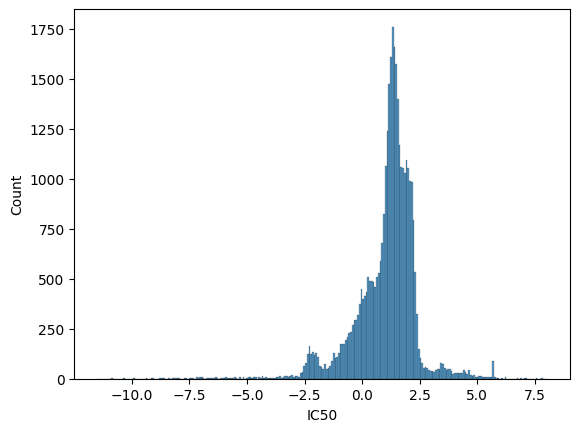

In [5]:
import seaborn as sns

sns.histplot(np.log(df['IC50']))

In [6]:
df


,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [17]:
df1 = df.copy()

In [18]:
descriptor_names = [desc[0] for desc in Descriptors._descList]
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
tqdm.pandas(desc="Calculating descriptors")

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return descriptor_calculator.CalcDescriptors(mol)
    else:
        return [None] * len(descriptor_names)

descriptor_df = pd.DataFrame(df1['SMILES'].progress_apply(calculate_descriptors).tolist(), columns=descriptor_names)
df1 = pd.concat([df1, descriptor_df], axis=1)

Calculating descriptors:   0%|          | 40/36377 [00:00<10:14, 59.13it/s][17:18:55] Conflicting single bond directions around double bond at index 55.
[17:18:55]   BondStereo set to STEREONONE and single bond directions set to NONE.
Calculating descriptors:  99%|█████████▊| 35833/36377 [08:59<00:09, 57.93it/s][17:27:54] Conflicting single bond directions around double bond at index 7.
[17:27:54]   BondStereo set to STEREONONE and single bond directions set to NONE.
Calculating descriptors: 100%|██████████| 36377/36377 [09:07<00:00, 66.41it/s]


In [19]:
# df1.to_csv('data_dsc_him.csv')

In [72]:
df1 = pd.read_csv('/kaggle/input/ml-2-hw/data_dsc_him.csv')

In [73]:
df1

,Unnamed: 0,IC50,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,11.743425,11.743425,0.061289,-4.487931,0.216971,25.916667,362.367,...,0,0,0,0,0,0,0,0,0,0
1,1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,11.324462,11.324462,0.124444,-0.959020,0.651957,25.571429,298.383,...,0,0,0,0,0,0,0,0,0,0
2,2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,11.521766,11.521766,0.025290,-1.252691,0.624022,25.333333,295.359,...,0,0,0,0,0,0,0,0,0,0
3,3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,11.271766,11.271766,0.000752,-1.236230,0.681758,26.250000,283.348,...,0,0,0,0,0,0,0,0,0,0
4,4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,11.745432,11.745432,0.243422,-1.443615,0.561612,10.708333,329.268,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,12.878883,12.878883,0.015136,-2.100949,0.190380,23.409091,622.839,...,0,0,0,0,0,0,0,0,0,0
36373,36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,10.902047,10.902047,0.007037,-1.145577,0.609570,9.529412,237.211,...,0,0,0,0,0,0,0,0,0,0
36374,36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,13.532099,13.532099,0.108041,-4.327131,0.046950,20.131148,866.987,...,0,1,0,0,0,0,0,0,4,0
36375,36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,11.663709,11.663709,0.021506,-1.114044,0.619049,9.900000,279.296,...,0,0,0,0,0,0,0,0,0,0


In [80]:
df1 = df1.dropna()
df1 = df1.drop_duplicates()
df1 = df1[(df1['IC50'] >= -3) & (df1['IC50'] <= 5)]
X = df1.drop(columns=['IC50', 'SMILES', 'Unnamed: 0'])
y = np.log(df1['IC50'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=5000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.023219
0:	learn: 1.2652317	total: 26.3ms	remaining: 2m 11s
500:	learn: 0.9898084	total: 7.56s	remaining: 1m 7s
1000:	learn: 0.9626490	total: 14.9s	remaining: 59.5s
1500:	learn: 0.9468462	total: 22.2s	remaining: 51.9s
2000:	learn: 0.9351663	total: 29.5s	remaining: 44.3s
2500:	learn: 0.9256817	total: 36.7s	remaining: 36.7s
3000:	learn: 0.9182772	total: 43.8s	remaining: 29.2s
3500:	learn: 0.9109498	total: 50.9s	remaining: 21.8s
4000:	learn: 0.9039358	total: 57.9s	remaining: 14.5s
4500:	learn: 0.8971011	total: 1m 5s	remaining: 7.24s
4999:	learn: 0.8901798	total: 1m 12s	remaining: 0us


In [21]:
df1 = df1.dropna()
X = df1.drop(columns=['IC50', 'SMILES'])
y = np.log(df1['IC50'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.042175
0:	learn: 1.3895652	total: 238ms	remaining: 7m 55s
500:	learn: 1.1004911	total: 8.87s	remaining: 26.5s
1000:	learn: 1.0602252	total: 16.9s	remaining: 16.9s
1500:	learn: 1.0372282	total: 24.8s	remaining: 8.26s
1999:	learn: 1.0202548	total: 32.9s	remaining: 0us


In [23]:
df2 = df.copy()

unique_chars = set(''.join(df2['SMILES']))
def generate_pairs(s):
    return [s[i:i+2] for i in range(len(s) - 1)]

unique_pairs = set()
for s in df2['SMILES']:
    unique_pairs.update(generate_pairs(s))

for char in unique_chars:
    df2[f'count_{char}'] = df2['SMILES'].apply(lambda x: x.count(char))

for pair in unique_pairs:
    df2[f'count_{pair}'] = df2['SMILES'].apply(lambda x: generate_pairs(x).count(pair))
df2['lenght'] = df2['SMILES'].map(lambda x: len(x))
df2

,IC50,SMILES,count_i,count_@,count_(,count_3,count_F,count_[,count_H,count_B,...,count_N6,count_3B,count_r),count_o[,count_.C,count_S[,count_7),count_O-,count_6N,lenght
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0,6,8,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,66
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0,5,6,0,0,3,3,0,...,0,0,0,0,0,0,0,0,0,52
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0,4,6,0,0,4,3,0,...,0,0,0,0,0,0,0,1,0,55
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0,4,6,0,0,4,3,0,...,0,0,0,0,0,0,0,1,0,53
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0,0,7,2,0,2,2,0,...,0,0,0,0,0,0,0,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,1,8,10,2,0,6,5,0,...,0,0,0,0,0,0,0,0,0,104
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,0,9,16,2,0,6,5,0,...,0,0,0,0,0,0,0,0,0,135
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35


In [25]:
df2.to_csv('him_val_counts.csv')

In [28]:
df2 = df2.dropna()
X = df2.drop(columns=['IC50', 'SMILES'])
y = np.log(df2['IC50'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=2000)
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

Learning rate set to 0.042177
0:	learn: 1.3933055	total: 28.1ms	remaining: 56.2s
500:	learn: 1.1473744	total: 6.77s	remaining: 20.3s
1000:	learn: 1.1180634	total: 13.4s	remaining: 13.3s
1500:	learn: 1.1007084	total: 19.9s	remaining: 6.62s
1999:	learn: 1.0891558	total: 26.6s	remaining: 0us


In [35]:
print(mean_squared_error(y_test, y_pred2))
print(r2_score(y_test, y_pred2))

1.4882795997075657
0.24027774458690376


In [9]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cb_tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model = AutoModel.from_pretrained('DeepChem/ChemBERTa-10M-MLM').to(device)
cb_model.eval()
df3 = df.copy()
def get_embeddings(smiles, tokenizer, model):
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings

embeddings_list = []
for smiles in tqdm(df3['SMILES'], desc="Extracting Embeddings"):
    embeddings_list.append(get_embeddings(smiles, cb_tokenizer, cb_model))

embeddings_df = pd.DataFrame(embeddings_list)
df3 = pd.concat([df3, embeddings_df], axis=1)
df3


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting Embeddings: 100%|██████████| 36377/36377 [02:07<00:00, 285.43it/s]


,Unnamed: 0,Title,IC50,SMILES,0,1,2,3,4,5,...,374,375,376,377,378,379,380,381,382,383
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,-0.016020,0.070028,-0.670418,0.261484,0.447424,0.078910,...,-0.342773,-0.116086,0.126895,-0.024237,0.068542,-0.299082,0.196709,-0.089450,0.225678,0.103603
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.122977,0.152097,-0.767348,0.436149,0.294495,0.211124,...,-0.424044,-0.336564,-0.127912,-0.089391,0.050350,-0.356858,0.196592,-0.248065,0.215766,0.141822
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,-0.022177,-0.197309,-0.633348,0.498295,0.507399,0.282044,...,-0.365801,-0.178342,0.143445,0.053074,-0.060730,-0.482792,0.591451,-0.416508,0.275518,0.319590
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,-0.002740,-0.153481,-0.671635,0.361890,0.462965,0.185842,...,-0.553320,-0.048143,0.198785,-0.027857,-0.063554,-0.442901,0.438766,-0.336855,0.067320,0.301781
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.518089,0.150754,-0.524464,0.553963,-0.032644,-0.312866,...,-0.281950,-0.265258,0.268160,0.041622,-0.176611,-0.224618,0.189005,-0.276626,0.251525,-0.051451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,NaN,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,0.000873,0.280286,-0.250047,0.536609,0.030387,0.300142,...,-0.059815,-0.192926,0.177187,0.228638,0.097042,0.119488,0.507633,0.032187,0.050472,0.333332
36373,NaN,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,0.328549,0.221010,-0.736150,0.112850,0.360615,0.193836,...,-0.660913,-0.103734,0.598989,0.025965,-0.180337,-0.051943,0.314053,-0.531865,0.080021,-0.163564
36374,NaN,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,0.215322,-0.010351,-0.254442,0.559554,-0.162524,0.099531,...,-0.050228,-0.007512,0.298205,0.221099,-0.044490,-0.234157,0.424112,-0.284446,0.045750,0.117098
36375,NaN,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,0.345231,0.174550,-0.555807,0.273543,0.511293,0.156644,...,-0.382537,-0.082138,0.472540,0.054859,-0.187398,-0.083487,0.274833,-0.585726,0.231275,0.203856


In [11]:
kek=df3

In [14]:
df3

,Title,IC50,SMILES,0,1,2,3,4,5,6,...,374,375,376,377,378,379,380,381,382,383
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,-0.016020,0.070028,-0.670418,0.261484,0.447424,0.078910,-0.265714,...,-0.342773,-0.116086,0.126895,-0.024237,0.068542,-0.299082,0.196709,-0.089450,0.225678,0.103603
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.122977,0.152097,-0.767348,0.436149,0.294495,0.211124,-0.496248,...,-0.424044,-0.336564,-0.127912,-0.089391,0.050350,-0.356858,0.196592,-0.248065,0.215766,0.141822
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,-0.022177,-0.197309,-0.633348,0.498295,0.507399,0.282044,-0.396712,...,-0.365801,-0.178342,0.143445,0.053074,-0.060730,-0.482792,0.591451,-0.416508,0.275518,0.319590
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,-0.002740,-0.153481,-0.671635,0.361890,0.462965,0.185842,-0.443994,...,-0.553320,-0.048143,0.198785,-0.027857,-0.063554,-0.442901,0.438766,-0.336855,0.067320,0.301781
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.518089,0.150754,-0.524464,0.553963,-0.032644,-0.312866,-0.681439,...,-0.281950,-0.265258,0.268160,0.041622,-0.176611,-0.224618,0.189005,-0.276626,0.251525,-0.051451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,0.000873,0.280286,-0.250047,0.536609,0.030387,0.300142,-0.339484,...,-0.059815,-0.192926,0.177187,0.228638,0.097042,0.119488,0.507633,0.032187,0.050472,0.333332
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,0.328549,0.221010,-0.736150,0.112850,0.360615,0.193836,-0.669397,...,-0.660913,-0.103734,0.598989,0.025965,-0.180337,-0.051943,0.314053,-0.531865,0.080021,-0.163564
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,0.215322,-0.010351,-0.254442,0.559554,-0.162524,0.099531,-0.607028,...,-0.050228,-0.007512,0.298205,0.221099,-0.044490,-0.234157,0.424112,-0.284446,0.045750,0.117098
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,0.345231,0.174550,-0.555807,0.273543,0.511293,0.156644,-0.573319,...,-0.382537,-0.082138,0.472540,0.054859,-0.187398,-0.083487,0.274833,-0.585726,0.231275,0.203856


In [16]:
df3 = df3.dropna()
X = df3.drop(columns=['IC50', 'SMILES', 'Title'])
y = np.log(df3['IC50'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=3000)
model.fit(X_train, y_train)
y_pred3 = model.predict(X_test)

Learning rate set to 0.033109
0:	learn: 1.3965856	total: 318ms	remaining: 15m 52s
500:	learn: 1.1165016	total: 12.5s	remaining: 1m 2s
1000:	learn: 1.0566776	total: 24.4s	remaining: 48.7s
1500:	learn: 1.0187985	total: 36.1s	remaining: 36s
2000:	learn: 0.9896139	total: 47.5s	remaining: 23.7s
2500:	learn: 0.9640561	total: 59.4s	remaining: 11.8s
2999:	learn: 0.9440239	total: 1m 10s	remaining: 0us


In [70]:
df3.to_csv('bert_df.csv')

In [17]:
print(mean_squared_error(y_test, y_pred3))
print(r2_score(y_test, y_pred3))

1.4652944613835022
0.2520109707441197


In [48]:
y_pred3

array([1.53147684, 1.09010984, 0.89370869, ..., 0.93154288, 1.58636116,
       1.04135369])

In [47]:
y_pred2

array([1.33230878, 1.07520439, 1.05493168, ..., 0.97821978, 2.2034686 ,
       0.86217051])

In [46]:
y_pred

array([1.39060012, 0.98875677, 0.89603532, ..., 1.40052433, 1.42796453,
       0.6151803 ])

In [51]:
print(len(y_pred3[:-1]))
print(len(y_pred2[:-1]))
# print(len(y_pred))

3637
3637
3637


In [82]:
all_preds = np.stack((y_pred, y_pred2[:-1], y_pred3[:-1]), axis=0)
mean_pred = np.mean(all_preds, axis=0)

In [2]:
print(mean_squared_error(y_test[:-1], mean_pred))
print(r2_score(y_test[:-1], mean_pred))

1.2698476392733442
0.3705233024589309


# Тесты

# Descr

In [43]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 48.7 MB/s eta 0:00:00:00:0100:01


In [22]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.notebook import tqdm
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

for descriptor_name in tqdm(Descriptors.descList):
    df[descriptor_name[0]] = df['Mol'].apply(descriptor_name[1])

df = df.drop(columns=['Mol'])

[20:07:01] Conflicting single bond directions around double bond at index 55.
[20:07:01]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:07:07] Conflicting single bond directions around double bond at index 7.
[20:07:07]   BondStereo set to STEREONONE and single bond directions set to NONE.


  0%|          | 0/210 [00:00<?, ?it/s]


KeyboardInterrupt



In [15]:
df.to_csv('/kaggle/working/descr_formula.csv')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='IC50', ylabel='Count'>

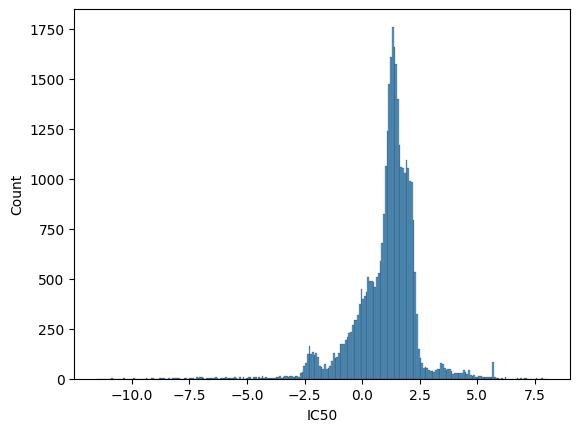

In [92]:
import seaborn as sns

sns.histplot(np.log(df['IC50']))

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
df = df.dropna()
# df = drop_duplicates()
# df = df[(df['IC50'] >= -10) & (df['IC50'] <= 7.5)]
X = df.drop(columns=['IC50', 'SMILES'])
y = np.log(df['IC50'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=5000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.024406
0:	learn: 1.3932842	total: 30.9ms	remaining: 2m 34s
500:	learn: 1.1290227	total: 8.41s	remaining: 1m 15s
1000:	learn: 1.0881370	total: 16.7s	remaining: 1m 6s
1500:	learn: 1.0657090	total: 24.8s	remaining: 57.7s
2000:	learn: 1.0494078	total: 33s	remaining: 49.4s
2500:	learn: 1.0371165	total: 41.2s	remaining: 41.2s
3000:	learn: 1.0265314	total: 49.5s	remaining: 33s
3500:	learn: 1.0171151	total: 57.5s	remaining: 24.6s
4000:	learn: 1.0078507	total: 1m 5s	remaining: 16.4s
4500:	learn: 1.0009665	total: 1m 13s	remaining: 8.2s
4999:	learn: 0.9946321	total: 1m 22s	remaining: 0us


In [22]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 1.2661537545375485
R2 Score: 0.3634628172074552


In [9]:
import numpy as np
X = np.array(embeddings_list)
X = X[:, :1000]

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
df = df.dropna()
# df = drop_duplicates()
# df = df[(df['IC50'] >= -10) & (df['IC50'] <= 7.5)]
# X = embeddings_list[:, :1000]
y = np.log(df['IC50'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=5000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.024406
0:	learn: 1.3977808	total: 91.3ms	remaining: 7m 36s
500:	learn: 1.1769811	total: 22.8s	remaining: 3m 25s
1000:	learn: 1.1241876	total: 45s	remaining: 2m 59s
1500:	learn: 1.0891504	total: 1m 6s	remaining: 2m 36s
2000:	learn: 1.0617315	total: 1m 28s	remaining: 2m 13s
2500:	learn: 1.0380519	total: 1m 50s	remaining: 1m 50s
3000:	learn: 1.0178126	total: 2m 12s	remaining: 1m 28s
3500:	learn: 0.9997111	total: 2m 34s	remaining: 1m 6s
4000:	learn: 0.9847475	total: 2m 55s	remaining: 43.9s
4500:	learn: 0.9690605	total: 3m 17s	remaining: 21.9s
4999:	learn: 0.9557722	total: 3m 39s	remaining: 0us


In [15]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 1.5634976879167912
R2 Score: 0.20188115860037115


In [4]:
from tqdm import tqdm 
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

smiles_list = df["SMILES"].tolist()
batch_size = 32
embeddings_list = []
for i in tqdm(range(0, len(smiles_list), batch_size)):
    batch = smiles_list[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.logits[:, 0, :].cpu().numpy()

    embeddings_list.extend(embeddings)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1137/1137 [01:59<00:00,  9.54it/s]


# value_counts

In [27]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_excel('/kaggle/input/ml-2-hw/19_35000.xlsx')
df.drop(columns=['Unnamed: 0', 'Title'], inplace=True)

In [28]:
unique_chars = set(''.join(df['SMILES']))

def generate_pairs(s):
    return [s[i:i+2] for i in range(len(s) - 1)]

unique_pairs = set()
for s in df['SMILES']:
    unique_pairs.update(generate_pairs(s))

for char in unique_chars:
    df[f'count_{char}'] = df['SMILES'].apply(lambda x: x.count(char))

for pair in unique_pairs:
    df[f'count_{pair}'] = df['SMILES'].apply(lambda x: generate_pairs(x).count(pair))
df['lenght'] = df['SMILES'].map(lambda x: len(x))
df

,IC50,SMILES,count_.,count_C,count_(,count_+,count_S,count_5,count_Z,count_=,...,count_7O,count_NS,count_9O,count_6N,count_S@,count_[s,count_2-,count_-n,count_4\,count_C4
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0,14,8,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0,15,6,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0,15,6,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0,14,6,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0,2,7,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,0,21,10,0,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,0,5,5,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,0,23,16,0,1,2,0,6,...,0,1,0,0,0,0,0,0,0,0
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,0,7,5,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df['lenght'] = df['SMILES'].map(lambda x: len(x))

In [26]:
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [22]:
# unique_chars = set(''.join(df['SMILES']))
# for char in unique_chars:
#     df[f'count_{char}'] = df['SMILES'].apply(lambda x: x.count(char))


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
df = df.dropna()
# df = drop_duplicates()
# df = df[(df['IC50'] >= -10) & (df['IC50'] <= 7.5)]
# Удаляем ненужные колонки
X = df.drop(columns=['IC50', 'SMILES'])
y = np.log(df['IC50'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=2000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.042177
0:	learn: 1.3935040	total: 25.4ms	remaining: 50.7s
500:	learn: 1.1503859	total: 6.53s	remaining: 19.5s
1000:	learn: 1.1213017	total: 12.9s	remaining: 12.9s
1500:	learn: 1.1071062	total: 19.2s	remaining: 6.37s
1999:	learn: 1.0943754	total: 25.6s	remaining: 0us


In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 1.4774153547213735
R2 Score: 0.2458236169524809


# meta model

In [65]:
X_train_2 = X_train[['IC50', 'SMILES']]
descriptor_names = [desc[0] for desc in Descriptors._descList]
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

from tqdm import tqdm

tqdm.pandas(desc="Calculating descriptors")
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return descriptor_calculator.CalcDescriptors(mol)
    else:
        return [None] * len(descriptor_names)

descriptor_df = pd.DataFrame(X_train_2['SMILES'].progress_apply(calculate_descriptors).tolist(), columns=descriptor_names)
X_train_2 = pd.concat([X_train_2, descriptor_df], axis=1)

Calculating descriptors:  45%|████▌     | 15562/34558 [03:53<04:59, 63.46it/s][18:01:39] Conflicting single bond directions around double bond at index 55.
[18:01:39]   BondStereo set to STEREONONE and single bond directions set to NONE.
Calculating descriptors:  74%|███████▎  | 25441/34558 [06:23<02:20, 64.66it/s][18:04:09] Conflicting single bond directions around double bond at index 7.
[18:04:09]   BondStereo set to STEREONONE and single bond directions set to NONE.
Calculating descriptors: 100%|██████████| 34558/34558 [08:41<00:00, 66.21it/s]


In [66]:
X_train_2

,IC50,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
5227,0.889,o1cccc1/C=C/[C@@H](NC2=O)Nc3sc(c4c23)CN(C)CC4,12.534998,12.534998,0.125823,-4.162495,0.254704,11.826087,352.803,339.699,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11933,2.495,O=Cc1c(C)n(c(C)c1)-c(cc2C(F)(F)F)c(cc2)N3CCOCC3,13.337194,13.337194,0.016659,-1.578478,0.450059,21.939394,509.308,492.172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23192,4.565,CCCCNC(=O)C(=O)N\N=C\c1cc(OC)c(cc1)OCC(=O)Nc2c...,10.927001,10.927001,0.230111,-0.932784,0.879276,12.444444,242.230,232.150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32535,8.660,c1ccc(F)cc1NC(=O)CN(C)C(=O)c2ccc(o2)-c3ccc(Cl)cc3,12.361164,12.361164,0.221267,-3.504516,0.944403,11.800000,310.444,292.300,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25268,5.134,N#Cc1ccc(cc1)CSc(n2)nc(N)cc2N,2.756851,2.756851,0.649686,0.649686,0.372555,46.354839,430.785,374.337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34523,NaN,NaN,12.069619,12.069619,0.113604,-0.113604,0.690522,10.916667,342.428,324.284,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34532,NaN,NaN,13.272028,13.272028,0.114974,-0.114974,0.287498,10.967742,472.421,451.253,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34536,NaN,NaN,5.492309,5.492309,0.562655,0.562655,0.485829,11.000000,337.404,322.284,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34544,NaN,NaN,12.426884,12.426884,0.003075,0.003075,0.894493,15.000000,293.410,270.226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
X_train_2 = X_train_2.dropna()
X = X_train_2.drop(columns=['IC50', 'SMILES'])
y = np.log(X_train_2['IC50'])

X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X, y, test_size=0.1, random_state=42)
model = CatBoostRegressor(task_type='GPU', verbose=500, iterations=2000)
model.fit(X_train_tr, y_train_tr)
y_pred = model.predict(X_test_tr)

Learning rate set to 0.041614
0:	learn: 1.2755367	total: 29.9ms	remaining: 59.9s
500:	learn: 1.2460249	total: 7.86s	remaining: 23.5s
1000:	learn: 1.2198733	total: 15.8s	remaining: 15.8s
1500:	learn: 1.1977840	total: 23.6s	remaining: 7.84s
1999:	learn: 1.1792705	total: 31.3s	remaining: 0us
